In [84]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [86]:
n = 55 #novel number
t = 'Wizard_OZ'#novel name
s = 32 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [87]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [88]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [89]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [90]:
df_novel.head()

,0
0,The Cyclone Dorothy lived in the midst of th...
1,"Their house was small, for the lumber to build..."
2,"There were four walls, a floor and a roof, whi..."
3,Uncle Henry and Aunt Em had a big bed in one c...
4,"There was no garret at all, and no cellar--exc..."


Create the wrd_length and total_char columns.

In [91]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [92]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [93]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [94]:
df_novel.head()

,0,wrd_length,total_char
0,The Cyclone Dorothy lived in the midst of th...,"[3, 7, 7, 5, 2, 3, 5, 2, 3, 5, 6, 8, 4, 5, 5, ...",113
1,"Their house was small, for the lumber to build...","[5, 5, 3, 5, 3, 3, 6, 2, 5, 2, 3, 2, 2, 7, 2, ...",69
2,"There were four walls, a floor and a roof, whi...","[5, 4, 4, 5, 1, 5, 3, 1, 4, 5, 4, 3, 4, 3, 4, ...",144
3,Uncle Henry and Aunt Em had a big bed in one c...,"[5, 5, 3, 4, 2, 3, 1, 3, 3, 2, 3, 6, 3, 7, 1, ...",75
4,"There was no garret at all, and no cellar--exc...","[5, 3, 2, 6, 2, 3, 3, 2, 6, 6, 1, 5, 4, 3, 2, ...",178


Create syllable count column

In [95]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [96]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [97]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [98]:
df_novel['syl_count'] = syl_count_arr

In [99]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,The Cyclone Dorothy lived in the midst of th...,"[3, 7, 7, 5, 2, 3, 5, 2, 3, 5, 6, 8, 4, 5, 5, ...",113,"[1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, ..."
1,"Their house was small, for the lumber to build...","[5, 5, 3, 5, 3, 3, 6, 2, 5, 2, 3, 2, 2, 7, 2, ...",69,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, ..."
2,"There were four walls, a floor and a roof, whi...","[5, 4, 4, 5, 1, 5, 3, 1, 4, 5, 4, 3, 4, 3, 4, ...",144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Uncle Henry and Aunt Em had a big bed in one c...,"[5, 5, 3, 4, 2, 3, 1, 3, 3, 2, 3, 6, 3, 7, 1, ...",75,"[1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 3, 1, ..."
4,"There was no garret at all, and no cellar--exc...","[5, 3, 2, 6, 2, 3, 3, 2, 6, 6, 1, 5, 4, 3, 2, ...",178,"[1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, ..."


In [100]:
df_novel.tail()

,0,wrd_length,total_char,syl_count
2234,"""Where in the world did you come from?""","[5, 2, 3, 5, 3, 3, 4, 4]",29,"[1, 1, 1, 1, 1, 1, 1, 1]"
2235,"""From the Land of Oz,"" said Dorothy gravely.","[4, 3, 4, 2, 2, 4, 7, 7]",33,"[1, 1, 1, 1, 1, 1, 3, 3]"
2236,"""And here is Toto, too.","[3, 4, 2, 4, 3]",16,"[1, 1, 1, 2, 1]"
2237,"And oh, Aunt Em!","[3, 2, 4, 2]",11,"[1, 1, 1, 1]"
2238,"I'm so glad to be at home again!""","[1, 2, 2, 4, 2, 2, 2, 4, 5]",24,"[1, 0, 1, 1, 1, 1, 1, 1, 2]"


In [101]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]
#df_novel = df_novel[df_novel['total_char'] > 2]

Create syllable sum column

In [102]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [103]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [104]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [105]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [106]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [107]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [108]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,The Cyclone Dorothy lived in the midst of th...,"[3, 7, 7, 5, 2, 3, 5, 2, 3, 5, 6, 8, 4, 5, 5, ...",113,[1 2 3 1 1 1 1 1 1 2 2 2 1 1 2 1 1 1 2 1 1 1 1...,36,0.80000
1,"Their house was small, for the lumber to build...","[5, 5, 3, 5, 3, 3, 6, 2, 5, 2, 3, 2, 2, 7, 2, ...",69,[1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1],22,0.12500
2,"There were four walls, a floor and a roof, whi...","[5, 4, 4, 5, 1, 5, 3, 1, 4, 5, 4, 3, 4, 3, 4, ...",144,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 2...,40,0.00000
3,Uncle Henry and Aunt Em had a big bed in one c...,"[5, 5, 3, 4, 2, 3, 1, 3, 3, 2, 3, 6, 3, 7, 1, ...",75,[1 2 1 1 1 1 1 1 0 1 1 2 1 3 1 1 0 1 3 2],25,-0.09375
4,"There was no garret at all, and no cellar--exc...","[5, 3, 2, 6, 2, 3, 3, 2, 6, 6, 1, 5, 4, 3, 2, ...",178,[1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 1...,57,0.23750


Create cluster dataframe - remove columns that can't be used

In [109]:
df_cluster = df_novel.drop('wrd_length', 1)

In [110]:
df_cluster = df_cluster.drop('syl_count', 1)

In [111]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,The Cyclone Dorothy lived in the midst of th...,113,36,0.80000
1,"Their house was small, for the lumber to build...",69,22,0.12500
2,"There were four walls, a floor and a roof, whi...",144,40,0.00000
3,Uncle Henry and Aunt Em had a big bed in one c...,75,25,-0.09375
4,"There was no garret at all, and no cellar--exc...",178,57,0.23750


Create 20 clusters on scaled data

In [112]:
X = df_cluster.drop(0, axis=1)

In [113]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [114]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [115]:
df_cluster['cluster'] = km.labels_

In [116]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,57.745098,18.245098,0.222249
1,121.710843,37.602410,-0.207736
2,31.404762,9.845238,-0.007241
3,99.106383,31.361702,0.806418
4,75.204545,22.965909,-0.236287
5,76.884211,24.068421,-0.006626
6,79.022222,25.488889,0.444507
7,167.348837,53.093023,0.417853
8,163.597938,50.608247,-0.015971


In [117]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [118]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

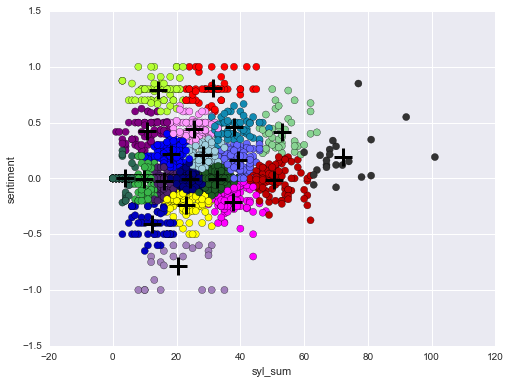

In [119]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [120]:
df_cluster_3 = df_cluster

In [121]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,The Cyclone Dorothy lived in the midst of th...,113,36,0.80000,3
1,"Their house was small, for the lumber to build...",69,22,0.12500,0
2,"There were four walls, a floor and a roof, whi...",144,40,0.00000,16
3,Uncle Henry and Aunt Em had a big bed in one c...,75,25,-0.09375,5
4,"There was no garret at all, and no cellar--exc...",178,57,0.23750,7


In [122]:
X = df_cluster_3.drop(0, axis=1)

In [123]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [124]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [125]:
df_cluster_3['cluster'] = km.labels_

In [126]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,29.780802,9.312321,-0.035960
1,126.460800,39.316800,0.141200
2,62.884279,19.733624,0.130329


Create 3 Clusters with no syl_sum

In [127]:
df_cluster_no_syl = df_cluster

In [128]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [129]:
X = df_cluster_no_syl.drop(0, axis=1)

In [130]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [131]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [132]:
df_cluster_no_syl['cluster'] = km.labels_

In [133]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,29.780802,-0.035960
1,59.172854,0.151742
2,126.116348,0.113151


Create 5 Clusters

In [134]:
df_cluster_5 = df_cluster

In [135]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,The Cyclone Dorothy lived in the midst of th...,113,36,0.80000,2
1,"Their house was small, for the lumber to build...",69,22,0.12500,2
2,"There were four walls, a floor and a roof, whi...",144,40,0.00000,1
3,Uncle Henry and Aunt Em had a big bed in one c...,75,25,-0.09375,2
4,"There was no garret at all, and no cellar--exc...",178,57,0.23750,1


In [136]:
X = df_cluster_5.drop(0, axis=1)

In [137]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [138]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [139]:
df_cluster_5['cluster'] = km.labels_

In [140]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,167.555000,52.155000,0.172032
1,29.500719,9.220144,-0.032877
2,55.243506,17.240260,-0.010549
3,108.111345,33.489496,0.053553
4,71.119048,22.813492,0.603102


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [141]:
df_novel['total_char'].sum()

157427

In [142]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [143]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [144]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:101]
df_novel['total_char'][101:224]
df_novel['total_char'][224:352]
df_novel['total_char'][352:473]
df_novel['total_char'][473:588]
df_novel['total_char'][588:686]
df_novel['total_char'][686:789]
df_novel['total_char'][789:886]
df_novel['total_char'][886:1000]
df_novel['total_char'][1000:1104]
df_novel['total_char'][1104:1214]
df_novel['total_char'][1214:1304]
df_novel['total_char'][1304:1392]
df_novel['total_char'][1392:1491]
df_novel['total_char'][1491:1631]
df_novel['total_char'][1631:1765]
df_novel['total_char'][1765:1900]
df_novel['total_char'][1900:2008]
df_novel['total_char'][2008:2127]
df_novel['total_char'][2127:2222]


In [145]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
101
0.0401273788093
101
224
0.0916100684546
224
352
0.0872193174303
352
473
0.0594260938786
473
588
0.0661677659096
588
686
0.0381913780664
686
789
0.070426715724
789
886
0.0651153486882
886
1000
0.135177305638
1000
1104
0.0721642564611
1104
1214
0.0565498874022
1214
1304
0.0295087715782
1304
1392
0.0775067264911
1392
1491
0.161612153279
1491
1631
0.0327632038927
1631
1765
0.104318038236
1765
1900
0.0998977807172
1900
2008
0.102679982697
2008
2127
0.0479548827107
2127
2222
0.200653489785


In [146]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.04012738  0.09161007  0.08721932  0.05942609  0.06616777  0.03819138
  0.07042672  0.06511535  0.13517731  0.07216426  0.05654989  0.02950877
  0.07750673  0.16161215  0.0327632   0.10431804  0.09989778  0.10267998
  0.04795488  0.20065349]


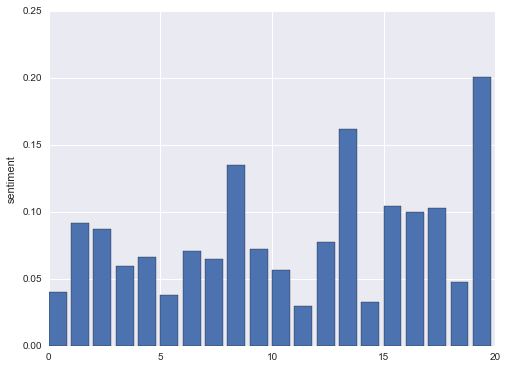

In [147]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [148]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
2234,"""Where in the world did you come from?""","[5, 2, 3, 5, 3, 3, 4, 4]",29,"[1, 1, 1, 1, 1, 1, 1, 1]",8,0.000
2235,"""From the Land of Oz,"" said Dorothy gravely.","[4, 3, 4, 2, 2, 4, 7, 7]",33,"[1, 1, 1, 1, 1, 1, 3, 3]",12,0.000
2236,"""And here is Toto, too.","[3, 4, 2, 4, 3]",16,"[1, 1, 1, 2, 1]",6,0.000
2237,"And oh, Aunt Em!","[3, 2, 4, 2]",11,"[1, 1, 1, 1]",4,0.000
2238,"I'm so glad to be at home again!""","[1, 2, 2, 4, 2, 2, 2, 4, 5]",24,"[1, 0, 1, 1, 1, 1, 1, 1, 2]",9,0.625


In [149]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [150]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:756]
df_novel['total_char'][756:1430]
df_novel['total_char'][1430:2232]


KeyboardInterrupt: 

In [151]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
756
0.0621118780635
756
1430
0.082824721935
1430
2232
0.0988946204489


In [152]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.06211188  0.08282472  0.09889462]


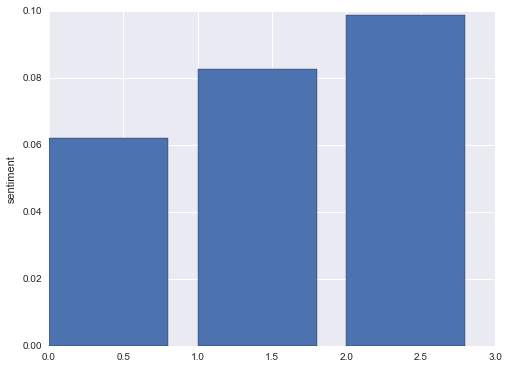

In [153]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers